<a href="https://colab.research.google.com/github/leukschrauber/LearningPortfolio/blob/main/learn_portfolio_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Portfolio
*by Fabian Leuk (csba6437/12215478)*

## Session 6: Hugging Face Pre-Trained Models

### Key Learnings




### Application

I will apply the knowledge gained throughout this session to my personal financial transactional data. I am using a transformers library to classify my financial transactions from 2022 into categories and create expense overviews.




### Data Preparation

I used the following code to label my financial transactions. As I found it quite inconvenient to do so in Google Colab, I did it on my local machine.

```
import os
import csv

directory = '/Users/fabian/Downloads/data/'
target_directory = '/Users/fabian/Downloads/labeled_data/'

expense_categories = {
    1: 'Groceries',
    2: 'Dining/Restaurants',
    3: 'Utilities',
    4: 'Transportation',
    5: 'Rent/Mortgage',
    6: 'Entertainment',
    7: 'Travel',
    8: 'Shopping',
    9: 'Health/Wellness',
    10: 'Education',
    11: 'Insurance',
    12: 'Investments',
    13: 'Miscellaneous',
    14: 'Hobbies',
    15: 'Home',
    16: 'Irrelevant'
}

def display_menu():
    print("Select a category:")
    items = list(expense_categories.items())

    # Calculate the maximum lengths of the second values
    max_value_length = max(len(pair[1]) for pair in items[1::2])

    # Iterate over the list and print key-value pairs
    for i in range(0, len(items), 2):
        pair1 = items[i]
        pair2 = items[i + 1] if i + 1 < len(items) else ('', '')  # Handle odd number of items

        print('{:<15}: {:<{value_width}}\t{:<15}: {:<{value_width}}'.format(pair1[0], pair1[1], pair2[0], pair2[1],
                                                                            value_width=max_value_length))


def get_category_choice():
    while True:
        try:
            choice = int(input("Enter the category number: "))
            if 0 <= choice <= 16:
                return choice
            else:
                print("Invalid category number. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")


for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='iso-8859-1', errors='replace') as csv_file:
            reader = csv.DictReader(csv_file, delimiter=";")
            fieldnames = reader.fieldnames[:-1] + ['Category']
            with open(os.path.join(target_directory + filename), 'a', newline='') as output_file:
              writer = csv.DictWriter(output_file, fieldnames=fieldnames, delimiter=';')
              writer.writeheader()
              for row in reader:
                print(row)
                display_menu()
                choice = get_category_choice()
                row['Category'] = expense_categories[choice]
                del row['']
                writer.writerow(row)
```



In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import data_table
from sklearn.model_selection import train_test_split

data_table.enable_dataframe_formatter()

drive.mount('/content/drive')

bank_account_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Bank_Account_2022.csv'
credit_card_data = '/content/drive/My Drive/SE_Digital_Organizations/transaction_data/Credit_Card_2022.csv'

data = pd.DataFrame()


bank_account_data = pd.read_csv(bank_account_data, delimiter=';')
credit_card_data = pd.read_csv(credit_card_data, delimiter=';')

credit_card_data.head(10)

data['text'] = pd.concat([bank_account_data["Auftraggeber / Begünstigter"],credit_card_data["Beschreibung"]])
data['labels'] = pd.concat([bank_account_data["Category"],credit_card_data["Category"]])
data['betrag'] = pd.concat([bank_account_data["Betrag (EUR)"],credit_card_data["Betrag (EUR)"]])
data['datum'] = pd.concat([bank_account_data["Wertstellung"],credit_card_data["Wertstellung"]])

data.head(10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,labels,betrag,datum
0,BBK Hagebaumarkt,Home,"-15,16",30.12.2022
1,Zika Shop,Transportation,"-9,24",30.12.2022
2,BAUHAUS 877,Home,"-82,50",29.12.2022
3,EDEKA EBLE,Groceries,"-28,63",29.12.2022
4,msg GillardonBSM AG,Irrelevant,"3.850,98",28.12.2022
5,Deutsche Kreditbank Berlin,Irrelevant,"-580,06",27.12.2022
6,EDEKA EBLE,Groceries,"-23,31",27.12.2022
7,Schlossberg Brasserie,Dining/Restaurants,"-6,50",27.12.2022
8,BURGER KING 8888,Dining/Restaurants,"-4,99",27.12.2022
9,Zeit fuer Brot -Schweiz,Groceries,"-7,20",22.12.2022


In [3]:
data['betrag'] = data['betrag'].str.replace('.', '').str.replace(',', '.').astype(float)
data['datum'] = pd.to_datetime(data['datum'])

<ipython-input-3-370278172a7b>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['betrag'] = data['betrag'].str.replace('.', '').str.replace(',', '.').astype(float)
<ipython-input-3-370278172a7b>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['datum'] = pd.to_datetime(data['datum'])


In [4]:
# Delete entries with empty text column
data = data[data['text'].notna()]

# Delete entries with label column corresponding to "Irrelevant"
data = data[data['labels'] != "Irrelevant"]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 0 to 271
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   text    618 non-null    object        
 1   labels  618 non-null    object        
 2   betrag  618 non-null    float64       
 3   datum   618 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 24.1+ KB


In [6]:
# Split into training and validation using stratified sampling
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['labels'], random_state=42)
train_data, validation_data = train_test_split(train_data, test_size=0.1, stratify=train_data['labels'], random_state=42)

print("Length of training, validation and test set")
print((len(train_data), len(validation_data), len(test_data)))

Length of training, validation and test set
(500, 56, 62)


In [7]:
!pip uninstall transformers -y

In [8]:
!pip install transformers==4.28.0
!pip install accelerate
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 11.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3

In [43]:
from transformers import AutoTokenizer, DataCollatorWithPadding, TrainingArguments, AutoModelForSequenceClassification, Trainer
from datasets import Dataset,DatasetDict

# Make data comply to transformers standard: text and labels
train_data_transformers = train_data.loc[:, ['text', 'labels']]
test_data_transformers = test_data.loc[:, ['text', 'labels']]
valid_data_transformers = validation_data.loc[:, ['text', 'labels']]

# convert to datasets
train_ds = Dataset.from_pandas(train_data_transformers)
valid_ds = Dataset.from_pandas(valid_data_transformers)
test_ds = Dataset.from_pandas(test_data_transformers)

dataset_dict = DatasetDict({'train': train_ds, 'validation': valid_ds, 'test': test_ds})

# model and tokenizer definition
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

id2label = {
    0: 'Home',
    1: 'Groceries',
    2: 'Dining/Restaurants',
    3: 'Utilities',
    4: 'Transportation',
    5: 'Rent/Mortgage',
    6: 'Entertainment',
    7: 'Travel',
    8: 'Shopping',
    9: 'Health/Wellness',
    10: 'Education',
    11: 'Insurance',
    12: 'Investments',
    13: 'Miscellaneous',
    14: 'Hobbies'
}
label2id = {value: key for key, value in id2label.items()}

In [44]:
# tokenize text and convert labels into label id
def tokenize_function(x):
    tokens = tokenizer(x['text'], truncation=True, padding=True)
    tokens["labels"] = [label2id[label] for label in x["labels"]]
    return tokens

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

Map:   0%|          | 0/62 [00:00<?, ? examples/s]

In [45]:
from transformers import BertForSequenceClassification
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("/content/drive/My Drive/SE_Digital_Organizations/checkpoints/", evaluation_strategy="epoch", 
                                  per_device_train_batch_size=32, per_device_eval_batch_size=32,
                                  num_train_epochs = 12, learning_rate = 5e-05)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=15, id2label=id2label, label2id=label2id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.008484,0.392857
2,No log,1.672888,0.607143
3,No log,1.411662,0.678571
4,No log,1.197536,0.714286
5,No log,1.059164,0.750000
6,No log,0.953440,0.803571
7,No log,0.861825,0.803571
8,No log,0.890225,0.803571
9,No log,0.895274,0.821429
10,No log,0.845761,0.803571


TrainOutput(global_step=192, training_loss=0.8211524486541748, metrics={'train_runtime': 29.419, 'train_samples_per_second': 203.95, 'train_steps_per_second': 6.526, 'total_flos': 64757544012000.0, 'train_loss': 0.8211524486541748, 'epoch': 12.0})

In [46]:
preds = trainer.predict(tokenized_datasets["test"])
preds

PredictionOutput(predictions=array([[ 1.90432668e-01,  6.34045124e+00,  2.70387232e-01,
        -2.04551332e-02, -1.54344067e-01, -9.40518916e-01,
        -4.26478446e-01, -7.30221152e-01, -5.94372451e-01,
        -9.03086901e-01, -3.05019230e-01, -4.88746315e-01,
        -6.75565064e-01, -3.09620023e-01, -5.30429900e-01],
       [-7.88380265e-01, -9.49184060e-01,  2.20297113e-01,
        -7.29560077e-01,  1.89795554e-01, -9.22931731e-01,
        -1.36279929e+00,  5.37070572e-01,  9.59004045e-01,
        -6.50861442e-01, -5.62557638e-01, -1.55978337e-01,
        -1.06453991e+00, -3.99682671e-01,  4.81439066e+00],
       [ 2.57255465e-01,  6.36543846e+00,  7.50205398e-01,
        -1.05737709e-01,  7.58958831e-02, -1.06969917e+00,
        -6.58664286e-01, -7.12480605e-01, -7.18324900e-01,
        -1.03538835e+00, -3.11823756e-01, -5.54989696e-01,
        -8.74365509e-01, -3.65479201e-01, -3.89037251e-01],
       [-4.81623225e-02, -9.49035734e-02, -7.89653301e-01,
        -2.44980708e-01,

In [47]:
single_hits = 0
triple_hits = 0
wrong_single_hits_per_category = {}
wrong_triple_hits_per_category = {}

for i in range(len(preds.predictions)):
  if np.argmax(preds.predictions[i]) == tokenized_datasets["test"][i]["labels"]:
    single_hits += 1
  else:
    if wrong_single_hits_per_category.get(id2label[tokenized_datasets["test"][i]["labels"]]) is None:
        wrong_single_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] = 1
    else:
        wrong_single_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] += 1
  if tokenized_datasets["test"][i]["labels"] in np.argpartition(preds.predictions[i], -3)[-3:]:
    triple_hits += 1
  else:
    if wrong_triple_hits_per_category.get(id2label[tokenized_datasets["test"][i]["labels"]]) is None:
        wrong_triple_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] = 1
    else:
        wrong_triple_hits_per_category[id2label[tokenized_datasets["test"][i]["labels"]]] += 1

sorted_single_hit_fails = dict(sorted(wrong_single_hits_per_category .items(), key=lambda x: x[1], reverse=True))
sorted_triple_hit_fails = dict(sorted(wrong_triple_hits_per_category .items(), key=lambda x: x[1], reverse=True))

print("Single and Triple Hit Accuracy")
print((single_hits/len(preds.predictions), triple_hits/len(preds.predictions)))
print("Category to wrong prediction single")
print(sorted_single_hit_fails)
print("Category to wrong prediction triple")
print(sorted_triple_hit_fails)

Single and Triple Hit Accuracy
(0.9193548387096774, 0.9516129032258065)
Category to wrong prediction single
{'Travel': 1, 'Dining/Restaurants': 1, 'Health/Wellness': 1, 'Hobbies': 1, 'Transportation': 1}
Category to wrong prediction triple
{'Health/Wellness': 1, 'Hobbies': 1, 'Transportation': 1}


In [48]:
# Initialize an empty list to store the results
results = []

# Apply np.argmax() to each array in the nested array
for arr in preds.predictions:
    max_index = np.argmax(arr)
    results.append(max_index)

print(results)

[1, 14, 1, 4, 7, 4, 11, 4, 14, 1, 1, 1, 3, 1, 12, 8, 8, 1, 2, 8, 2, 3, 4, 2, 4, 12, 14, 1, 1, 6, 0, 11, 4, 8, 1, 4, 5, 3, 1, 1, 4, 2, 1, 1, 1, 13, 13, 1, 8, 6, 14, 14, 4, 13, 2, 12, 4, 2, 2, 2, 11, 5]


In [51]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(tokenized_datasets["test"]["labels"], results)
class_names = list(label2id.keys())
class_names.remove("Health/Wellness")

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  5]]


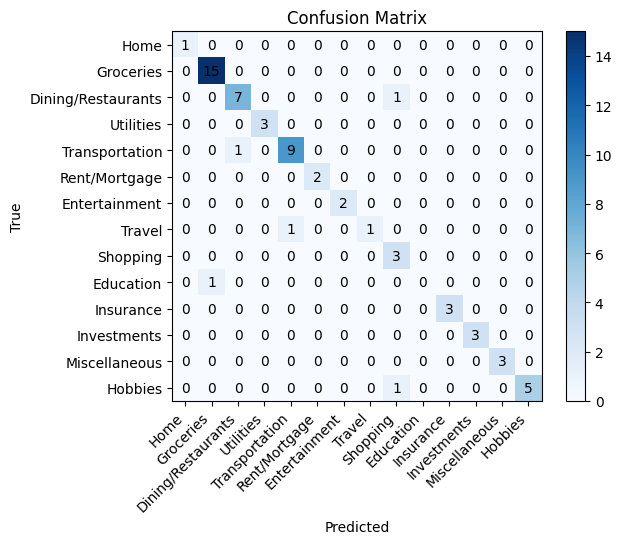

In [52]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(cm, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Set the title of the plot
ax.set_title('Confusion Matrix')

# Create tick labels
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

# Loop over the data and create text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Display the plot
plt.show()

In [68]:



import pandas as pd
import numpy as np
from plotly import graph_objects as go

RED = "rgba(245,173,168,0.6)"
GREEN = "rgba(211,255,216,0.6)"

def plot_confusion_matrix_as_sankey(confusion_matrix,  class_labels = None):
    
    """
    plots sankey diagram from confusion matrix and class labels
    
    The function acceps:
        - confusion_matrix
                [[TP, FN]
                 [FP, TN]]
        - class_labels:
            class_labels[0]: Label for positive class
            class_labels[1]: Label for negative class
        
    """
    
    df, labels = create_df_from_confusion_matrix(confusion_matrix,  class_labels)
    
    fig = go.Figure(data=[go.Sankey(
    
    node = dict(
      pad = 100,
      thickness = 100,
      line = dict(color = "gray", width = 1.0),
      label = labels,
      color = GREEN,
      hovertemplate = "%{label} has total %{value:d} instances<extra></extra>"
    ),
    link = dict(
      source = df.actual, 
      target = df.predicted,
      value = df.instances,
      color = df.colour,
      customdata = df['link_text'], 
      hovertemplate = "%{customdata}<extra></extra>"  
    ))])

    fig.update_layout(title_text="Confusion Matrix Sankey Diagram", font_size=15,
                      width=1600, height=800)
    
    return fig

def create_df_from_confusion_matrix(confusion_matrix, class_labels=None):
    
    
    ## create a dataframe
    if not len(class_labels):
        ## if class labels not received, created dummy headers and index
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True Class-{i+1}" for i in range(confusion_matrix.shape[0])],
                          columns=[f"Predicted Class-{i+1}" for i in range(confusion_matrix.shape[0])])
    else:
        ## create headers and index using class labels
        df = pd.DataFrame(data=confusion_matrix, 
                          index=[f"True {i}" for i in class_labels],
                          columns=[f"Predicted {i}" for i in class_labels])
    
    ## unpivot dataframe and rename columns
    df = df.stack().reset_index()
    df.rename(columns={0:'instances', 'level_0':'actual', 'level_1':'predicted'}, inplace=True)
    """
    >>> df
            actual          predicted     instances
          True Fraud    Predicted Fraud       10
          True Fraud    Predicted Legit       4
          True Legit    Predicted Fraud       2
          True Legit    Predicted Legit       12
    
    """
    
    ## determine classification color based on correct classification or not.
    df["colour"] = df.apply(lambda x: 
                               GREEN if x.actual.split()[1:] == x.predicted.split()[1:] 
                               else RED, axis=1)

    node_labels = pd.concat([df.actual, df.predicted]).unique()
    node_labels_indices = {label:index for index, label in enumerate(node_labels)}
    
    ## map actual and predicted columns to numbers
    df =  df.assign(actual    = df.actual.apply(lambda x: node_labels_indices[x]),
                    predicted = df.predicted.apply(lambda x: node_labels_indices[x]))
    
    ## determine text for hovering on connecting edges of sankey diagram
    def get_link_text(row):
        if row["colour"] == GREEN:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances correctly classified as {target_class}"
        else:
            instance_count = row["instances"]
            source_class = ' '.join(node_labels[row['actual']].split()[1:])
            target_class = ' '.join(node_labels[row['predicted']].split()[1:])
            return f"{instance_count} {source_class} instances incorrectly classified as {target_class}"
        
    df["link_text"] = df.apply(get_link_text, axis = 1)
    return df, node_labels

confusion_matrix = np.array([[10, 4],
                             [2, 20]])

plot_confusion_matrix_as_sankey(cm,  class_names)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# Example confusion matrix with 4 classes
conf_matrix = np.array([[10, 5, 2, 3],
                       [4, 20, 3, 5],
                       [2, 4, 15, 3],
                       [3, 5, 3, 18]])

# Compute the flow values from the confusion matrix
flows = []
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        flows.append(conf_matrix[i, j])

# Set the labels for the flows
labels = ['Class A', 'Class B', 'Class C', 'Class D']

# Set the color for the flows
colors = ['blue', 'orange', 'green', 'red']

# Create a figure and axes
fig, ax = plt.subplots()

# Create a Sankey diagram
sankey = Sankey(ax=ax, unit=None)
sankey.add(flows=flows, labels=labels, orientations=[-1, 1, 0, 1], color=colors)
sankey.finish()

# Set the title of the plot
ax.set_title('Confusion Matrix - Sankey Diagram')

# Display the plot
plt.show()